<a href="https://colab.research.google.com/github/Enrique720/Proyecto-BigData/blob/main/Proyecto_Opencv_Jeanlee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [ ]:
import cv2
import random
from google.colab.patches import cv2_imshow

In [31]:
def horizontal_flip(img, flag=True):
    if flag: return cv2.flip(img, 1)
    else: return img


In [32]:
def vertical_flip(img, flag=True):
    if flag: return cv2.flip(img, 0)
    else: return img


In [49]:
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img


In [ ]:
def resize(img, width, height):
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized
 

## Augmentated data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import os
import os.path
from os import path
import shutil

In [69]:
%%time

n_final = 1000

base_folder = '/content/drive/MyDrive/BIG_DATA/RAW_FISH_DATASET/'
final_folder = '/content/drive/MyDrive/BIG_DATA/OPENCV1000/'

if path.isdir(final_folder):
  shutil.rmtree(final_folder)
os.mkdir(final_folder)

dirs = next(os.walk(base_folder))[1]

for species in dirs:
  raw_folder = base_folder + species + '/'
  out_folder = final_folder + species + '/'
  os.mkdir(out_folder)

  files = next(os.walk(raw_folder))[2]
  proportion = n_final // len(files)

  for cont, img_name in enumerate(files):
    f_name = os.path.splitext(img_name)[0]
    img = cv2.imread(raw_folder + img_name)
    img = resize(img, 590, 445)
    for i in range(proportion):
      if (i/2): img = horizontal_flip(img)
      if (i%2): img = vertical_flip(img)
      img = rotation(img, 30+i+cont)
      cv2.imwrite(out_folder+f_name+'_'+str(i)+'.png',img)


CPU times: user 3min 10s, sys: 12.1 s, total: 3min 22s
Wall time: 4min 41s


Para 1000 imagenes por clase:

CPU times: user 3min 9s, sys: 12.2 s, total: 3min 21s
Wall time: 4min 43s

# CNN Model

## Read data

In [52]:
import numpy as np # linear algebra
import pandas as pd
from pathlib import Path

In [53]:
dataset_path = Path(r'/content/OPENCV')

file_path = list(dataset_path.glob(r'**/*.png'))

# create labels from the folder name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [54]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/OPENCV/Shrimp/00033_4.png,Shrimp
1,/content/OPENCV/Shrimp/00014_3.png,Shrimp
2,/content/OPENCV/Shrimp/00008_3.png,Shrimp
3,/content/OPENCV/Shrimp/00029_0.png,Shrimp
4,/content/OPENCV/Shrimp/00002_1.png,Shrimp


In [55]:
df.label.value_counts()

Gilt Head Bream       300
Shrimp                300
Sea Bass              300
Horse Mackerel        300
Trout                 300
Red Sea Bream         300
Striped Red Mullet    300
Black Sea Sprat       300
Red Mullet            300
Name: label, dtype: int64

## Create train, test and validation dataset

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [58]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (1512, 2)
Shape of test data (810, 2)
Shape of validation data (378, 2)


In [59]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [60]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 1512 validated image filenames belonging to 9 classes.
Found 810 validated image filenames belonging to 9 classes.
Found 378 validated image filenames belonging to 9 classes.


Define the model

In [61]:
input_shape = (200, 200, 3)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [62]:
from tensorflow.keras.optimizers import Adam

## Train the model

In [63]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train, validation_data=val, epochs=20, callbacks=callback)

Epoch 1/20
48/48 [==============================] - 175s 4s/step - loss: 2.1233 - accuracy: 0.1495 - val_loss: 1.9436 - val_accuracy: 0.2116
Epoch 2/20
48/48 [==============================] - 171s 4s/step - loss: 1.8843 - accuracy: 0.2480 - val_loss: 1.7726 - val_accuracy: 0.2275
Epoch 3/20
48/48 [==============================] - 172s 4s/step - loss: 1.6926 - accuracy: 0.2685 - val_loss: 1.7345 - val_accuracy: 0.2804
Epoch 4/20
48/48 [==============================] - 172s 4s/step - loss: 1.6316 - accuracy: 0.3069 - val_loss: 1.5671 - val_accuracy: 0.3228
Epoch 5/20
48/48 [==============================] - 172s 4s/step - loss: 1.5550 - accuracy: 0.3380 - val_loss: 1.4824 - val_accuracy: 0.3519
Epoch 6/20
48/48 [==============================] - 172s 4s/step - loss: 1.5140 - accuracy: 0.3353 - val_loss: 1.5304 - val_accuracy: 0.3333
Epoch 7/20
48/48 [==============================] - 171s 4s/step - loss: 1.4939 - accuracy: 0.3512 - val_loss: 1.5513 - val_accuracy: 0.3122
Epoch 8/20
48

Tiempo: 1h
(3658.069s)

In [66]:
model.save('model-opencv.h5')

## Verify model's performance

In [67]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

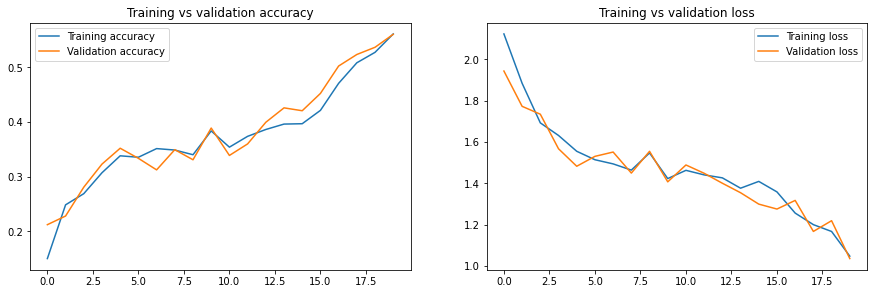

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()